1. Get the disaster data from EM-DAT

In [83]:
import pandas as pd
df_emdat = pd.read_csv('emdat.csv', encoding='latin1')
df_emdat.head()

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,2020-0089-USA,No,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,USA,...,NaN,NaN,NaN,NaN,175000.0,206030.0,84.939198,"[{""adm1_code"":3238,""adm1_name"":""Mississippi""},...",2020-03-09,2024-04-12
1,2024-0671-USA,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Francine',USA,...,NaN,NaN,NaN,NaN,1300000.0,NaN,NaN,NaN,2024-09-24,2025-01-22
2,2021-0526-USA,No,nat-cli-wil-for,Natural,Climatological,Wildfire,Forest fire,NaN,Caldor fire,USA,...,NaN,NaN,NaN,NaN,1500000.0,1686729.0,88.929493,"[{""adm2_code"":28873,""adm2_name"":""El Dorado""}]",2021-08-19,2025-03-18
3,2021-0741-USA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,USA,...,NaN,NaN,NaN,NaN,200000.0,224897.0,88.929493,"[{""adm2_code"":31666,""adm2_name"":""Whatcom""}]",2021-11-17,2023-09-25
4,2023-0122-USA,No,nat-met-sto-sto,Natural,Meteorological,Storm,Storm (General),NaN,NaN,USA,...,NaN,NaN,4200000.0,4200000.0,6000000.0,6000000.0,100.000000,"[{""adm1_code"":3214,""adm1_name"":""Alabama""},{""ad...",2023-03-15,2024-01-17


In [84]:
print(df_emdat.columns.tolist())

['DisNo.', 'Historic', 'Classification Key', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region', 'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal', 'Declaration', "AID Contribution ('000 US$)", 'Magnitude', 'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day', 'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless', 'Total Affected', "Reconstruction Costs ('000 US$)", "Reconstruction Costs, Adjusted ('000 US$)", "Insured Damage ('000 US$)", "Insured Damage, Adjusted ('000 US$)", "Total Damage ('000 US$)", "Total Damage, Adjusted ('000 US$)", 'CPI', 'Admin Units', 'Entry Date', 'Last Update']


In [85]:
event_subset = df_emdat[
    df_emdat['Disaster Type'].isin(['Wildfire', 'Drought']) &
    df_emdat[['Start Year', 'Start Month']].notna().all(axis=1)
]

event_subset['Start_Date'] = pd.to_datetime(
    event_subset.rename(columns={'Start Year': 'year', 'Start Month': 'month'})[['year', 'month']].assign(day=1)
).dt.to_period('M')
event_subset['End_Date'] = pd.to_datetime(
    event_subset.rename(columns={'End Year': 'year', 'End Month': 'month'})[['year', 'month']].assign(day=1)
).dt.to_period('M')


expanded_events = []
for _, row in event_subset.iterrows():
    months = pd.period_range(row['Start_Date'], row['End_Date'], freq='M')
    for m in months:
        expanded_events.append({'Country': row['Country'].upper(), 'Month': m, 'Event_Flag': 1})
event_expanded_df = pd.DataFrame(expanded_events)

<ipython-input-85-5cee58fa6f5e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_subset['Start_Date'] = pd.to_datetime(
<ipython-input-85-5cee58fa6f5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_subset['End_Date'] = pd.to_datetime(


2. Get the searching data from Google Trends

In [86]:
df_trend = pd.read_csv('Patagonia_Trend.csv')
df_trend.head()

,Month,Patagonia: (United States)
0,2020-01,65
1,2020-02,66
2,2020-03,39
3,2020-04,38
4,2020-05,42


In [87]:
df_trend.columns = ['Month', 'Searching_Volume_Patagonia']
df_trend['Month'] = pd.to_datetime(df_trend['Month']).dt.to_period('M')
df_trend['Country'] = 'UNITED STATES OF AMERICA'

In [88]:
merged_df = pd.merge(df_trend, event_expanded_df, on=['Country', 'Month'], how='left')
merged_df['Event_Flag'] = merged_df['Event_Flag'].fillna(0)
merged_df.head()

,Month,Searching_Volume_Patagonia,Country,Event_Flag
0,2020-01,65,UNITED STATES OF AMERICA,1.0
1,2020-02,66,UNITED STATES OF AMERICA,1.0
2,2020-03,39,UNITED STATES OF AMERICA,1.0
3,2020-04,38,UNITED STATES OF AMERICA,1.0
4,2020-05,42,UNITED STATES OF AMERICA,1.0


3. Visualize merged data

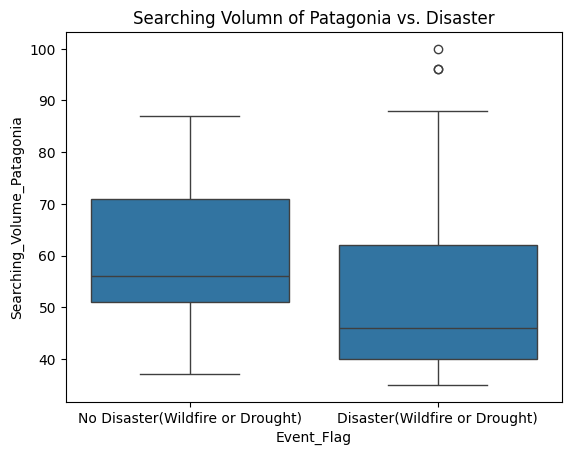

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=merged_df, x='Event_Flag', y='Searching_Volume_Patagonia')
plt.xticks([0,1], ['No Disaster(Wildfire or Drought)','Disaster(Wildfire or Drought)'])
plt.title("Searching Volumn of Patagonia vs. Disaster")
plt.show()

4. Regression Analysis

In [90]:
import statsmodels.formula.api as smf

model = smf.ols('Searching_Volume_Patagonia ~ Event_Flag', data=merged_df).fit()
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     Searching_Volume_Patagonia   R-squared:                       0.016
Model:                                    OLS   Adj. R-squared:                  0.005
Method:                         Least Squares   F-statistic:                     1.454
Date:                        Thu, 10 Apr 2025   Prob (F-statistic):              0.231
Time:                                18:17:29   Log-Likelihood:                -390.57
No. Observations:                          93   AIC:                             785.1
Df Residuals:                              91   BIC:                             790.2
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In this analysis, we found the coefficient is not statistically significant. In the next step, I would like to focus on a more specific area (LA), and expand the time period to 15 years.